## **Reversal / Momentum - Time Horizon**
In this we will investigate the phenomenon of reversal at shorter time horizons and momentum at longer time horizons using 4-hour cryptocurrency price data. The process will begin by executing the provided code, which downloads price data from Binance covering the period from January 2020 to December 2022. The subsequent returns will be calculated and stored in the variable ret.

1. Using the ret data, we will construct rank-demeaned-normalized excess (XS) reversal strategies for the following time horizons: 4, 8, 12, 16, 20, and 24 hours.
2. For instance, to develop the 12-hour strategy, we will calculate the average return from the previous three 4-hour bars and create a rank-demeaned-normalized XS portfolio to hold for the subsequent 4 hours.
3. We will then compute the Sharpe ratios for the reversal strategy across these different time horizons.
4. This analysis will help us identify the time frames where reversal effects are prominent compared to those where momentum is observed.
5. It is important to note that the first 4-hour bar often exhibits the strongest reversal effects. To account for this, we will apply a lag to the portfolio by one 4-hour bar. This adjustment should enhance the visibility of any momentum effects present.

In [ ]:
pip install python-binance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 15.1 MB/s eta 0:00:00


In [ ]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd
import numpy as np

#client = bnb_client()
###  if you're in the US, use:
client = bnb_client(tld='US')#" here instead

def get_binance_px(symbol,freq,start_ts = '2020-01-01',end_ts='2022-12-31'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)

    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '4h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

<ipython-input-3-6f7a80297512>:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change()


In [ ]:
strats = {}
for hor in [1,2,3,4,5,6]:
    avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    strats[hor] = (avg_ret.shift()*ret).sum(1)
strats = pd.DataFrame(strats)

We get reversal at horizons of <=8 hours. Momentum exists at longer horizons.

In [ ]:
sr = strats.mean()/strats.std()*np.sqrt(252*24/4)
sr

,0
1,-2.084589
2,-0.498395
3,0.549744
4,0.915015
5,1.185069
6,0.171836


In [ ]:
sr = strats.resample('A').mean()/strats.resample('A').std()*np.sqrt(252*24/4)

<ipython-input-6-5ef980cf032e>:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  sr = strats.resample('A').mean()/strats.resample('A').std()*np.sqrt(252*24/4)


<Axes: >

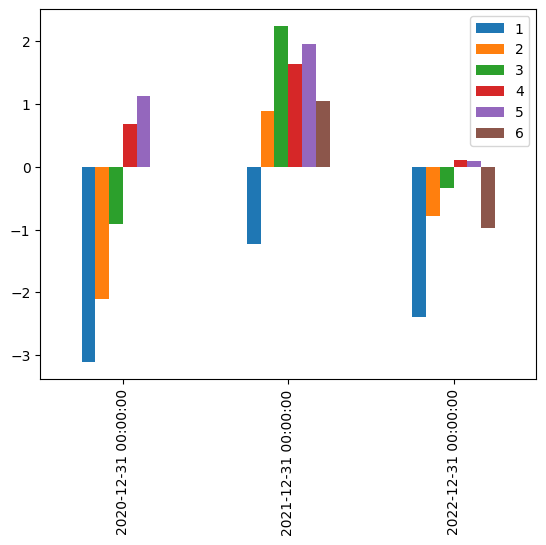

In [ ]:
sr.plot(kind='bar')

In [ ]:
strats_lag = {}
for hor in [1,2,3,4,5,6]:
    avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    strats_lag[hor] = (avg_ret.shift(2)*ret).sum(1)
strats_lag = pd.DataFrame(strats_lag)

Skipping the most recent bar bumps up the momentum effect significantly, and we now see positive sharpes as high as ~3.

In [ ]:
sr_lag = strats_lag.mean()/strats_lag.std()*np.sqrt(252*24/4)
sr_lag

,0
1,0.719756
2,1.676902
3,1.483746
4,1.444702
5,0.546445
6,0.651281


# **Getting all the plots and figures that are necessary**

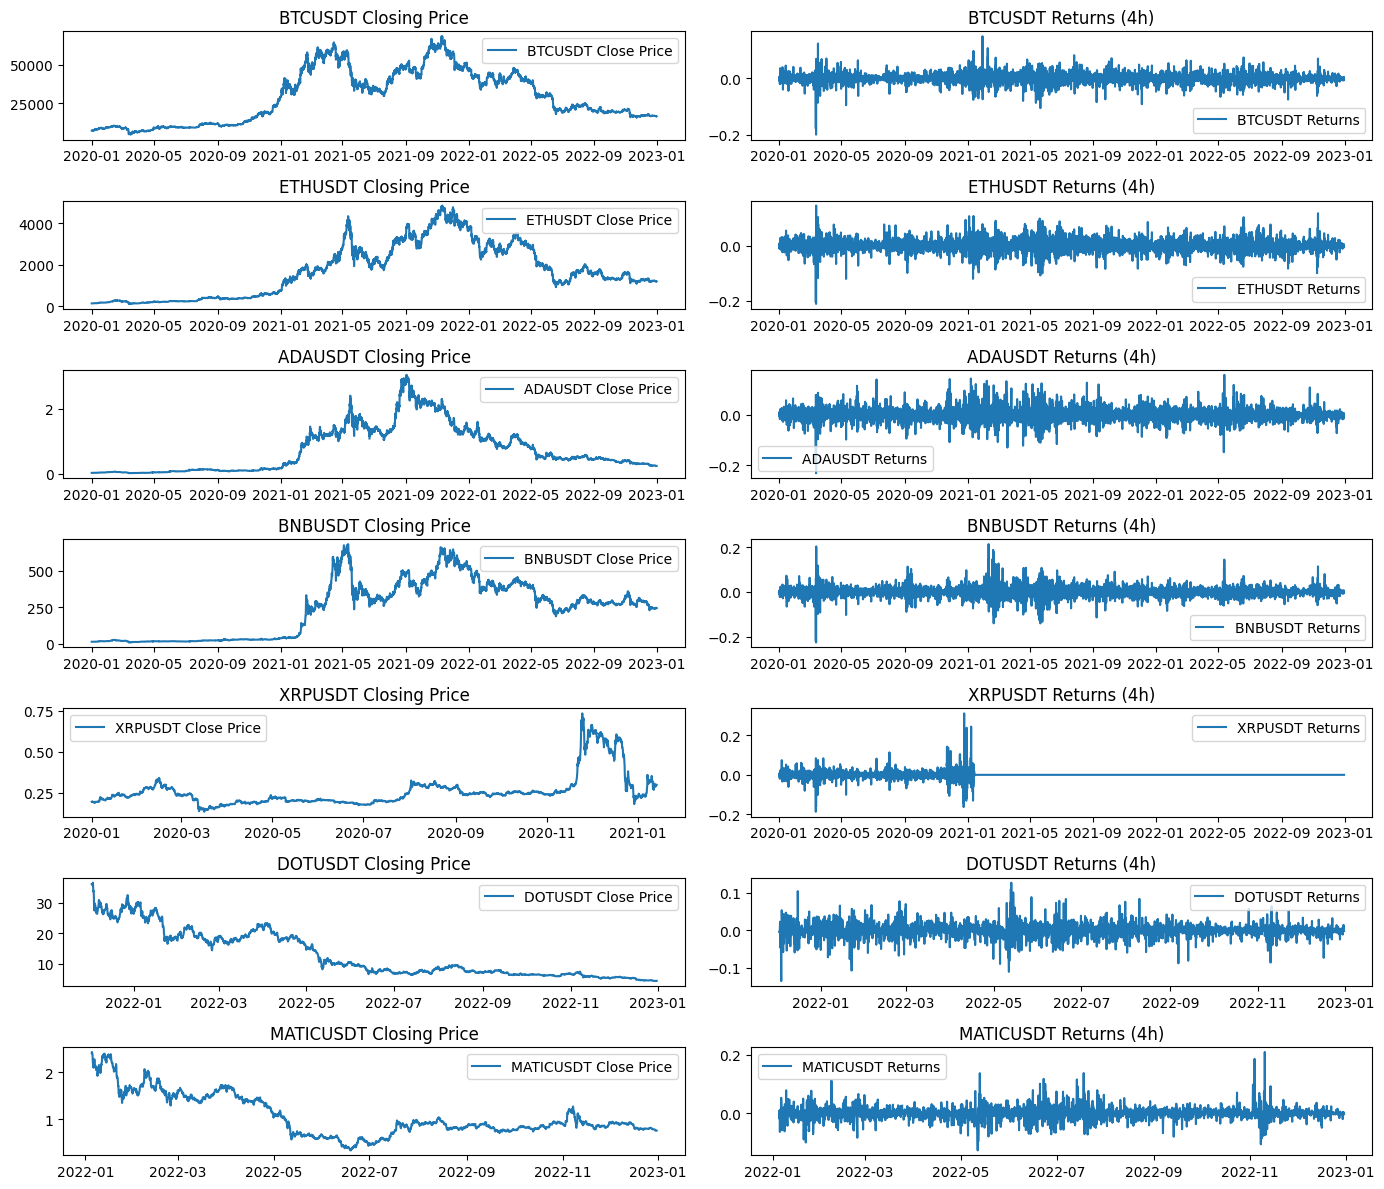

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'px' contains the closing prices and 'ret' contains the returns for all cryptocurrencies
plt.figure(figsize=(14, 12))

# Loop through each cryptocurrency in the universe
for i, symbol in enumerate(px.columns):
    plt.subplot(len(px.columns), 2, i * 2 + 1)  # Create a subplot for each closing price
    plt.plot(px[symbol], label=f'{symbol} Close Price')
    plt.title(f'{symbol} Closing Price')
    plt.legend()

    plt.subplot(len(px.columns), 2, i * 2 + 2)  # Create a subplot for each returns
    plt.plot(ret[symbol], label=f'{symbol} Returns')
    plt.title(f'{symbol} Returns (4h)')
    plt.legend()

plt.tight_layout()
plt.show()

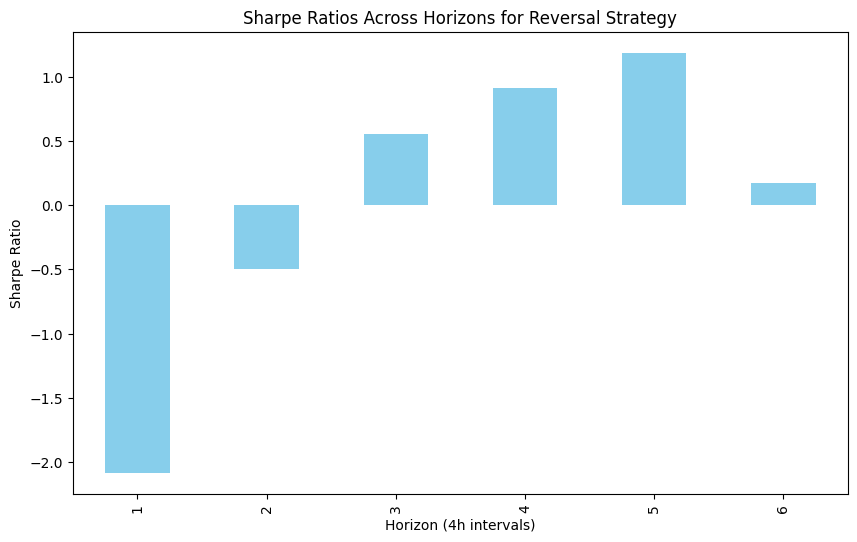

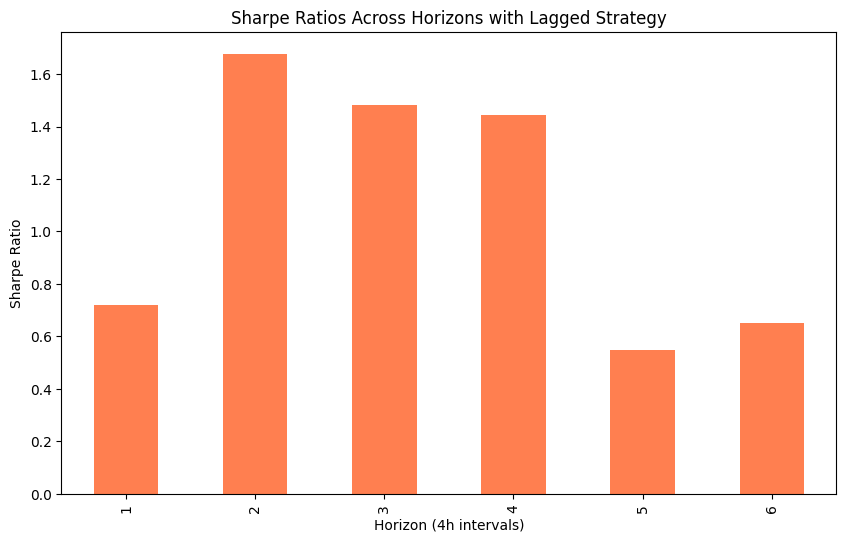

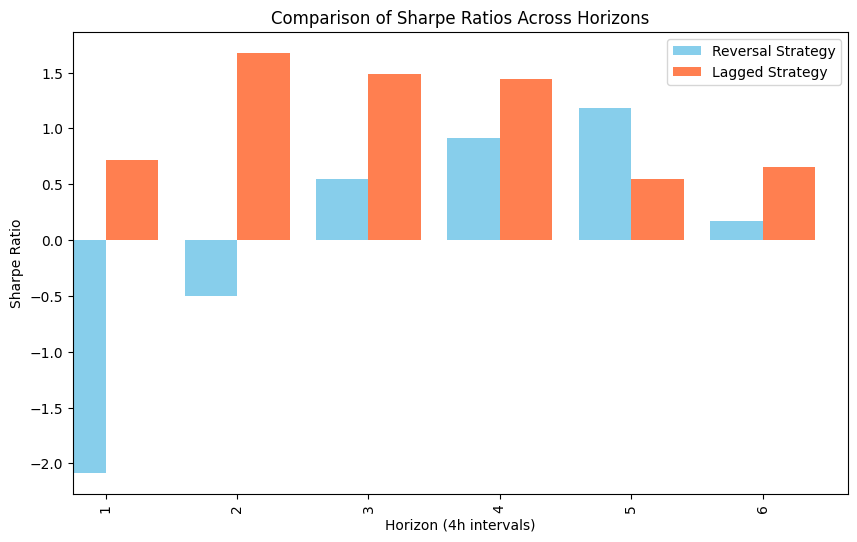

In [ ]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

strats = {}
for hor in [1, 2, 3, 4, 5, 6]:  # Corresponds to 4h, 8h, ..., 24h
    avg_ret = ret.rolling(hor, min_periods=1).mean().rank(axis=1)
    avg_ret = avg_ret.subtract(avg_ret.mean(axis=1), axis=0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(axis=1), axis=0)
    strats[hor] = (avg_ret.shift() * ret).sum(axis=1)
strats = pd.DataFrame(strats)

# Plot Sharpe Ratios across horizons for the reversal strategy
sr = strats.mean() / strats.std() * np.sqrt(252 * 24 / 4)
plt.figure(figsize=(10, 6))
sr.plot(kind='bar', color='skyblue')
plt.title('Sharpe Ratios Across Horizons for Reversal Strategy')
plt.xlabel('Horizon (4h intervals)')
plt.ylabel('Sharpe Ratio')
plt.show()

# Apply lag to the strategy to skip the first 4h bar
strats_lag = {}
for hor in [1, 2, 3, 4, 5, 6]:
    avg_ret = ret.rolling(hor, min_periods=1).mean().rank(axis=1)
    avg_ret = avg_ret.subtract(avg_ret.mean(axis=1), axis=0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(axis=1), axis=0)
    strats_lag[hor] = (avg_ret.shift(2) * ret).sum(axis=1)
strats_lag = pd.DataFrame(strats_lag)

# Plot Sharpe Ratios with lagged strategy across horizons
sr_lag = strats_lag.mean() / strats_lag.std() * np.sqrt(252 * 24 / 4)
plt.figure(figsize=(10, 6))
sr_lag.plot(kind='bar', color='coral')
plt.title('Sharpe Ratios Across Horizons with Lagged Strategy')
plt.xlabel('Horizon (4h intervals)')
plt.ylabel('Sharpe Ratio')
plt.show()

# Combined Sharpe Ratio plot for comparison
plt.figure(figsize=(10, 6))
sr.plot(kind='bar', color='skyblue', position=1, width=0.4, label='Reversal Strategy')
sr_lag.plot(kind='bar', color='coral', position=0, width=0.4, label='Lagged Strategy')
plt.title('Comparison of Sharpe Ratios Across Horizons')
plt.xlabel('Horizon (4h intervals)')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()
